# Constructing PCEs with multiple input distributions

## Problem Description
This example uses an Euler-Bernoulli beam model to illustrate the use of generalized polynomial chaos (gPC) for forward uncertainty quantification.  Uncertainties in the stiffness of the beam and load applied to it are represented probabilistically with different distributions (lognormal and uniform) and the distribution of the displacement is represented with an appropriate polynomial expansion.  

<img src="BeamDrawing.png" width=300px>

### Model Formulation:

Let $u(x)$ denote the vertical deflection of the beam and let $f(x)$ denote the vertical force acting on the beam at point $x$ (positive for upwards, negative for downwards).  We assume the displacement of the beam can be well approximated using Euler-Bernoulli beam theory and thus satisfies the PDE
$$
\frac{\partial^2}{\partial x^2}\left[ \exp[m(x)] \frac{\partial^2 u}{\partial x^2}\right] = f(x),
$$
where $K(x)=\exp[m(x)]$ is an effective stiffness that depends both on the beam geometry and material properties.  Our goal is to probabilistically characterize uncertainty in the displacement $u(x)$ that is caused by uncertainty in the log stiffness $m(x)$ and load $f(x)$.  Note that any model error stemming from the form of the Euler-Bernoulli PDE is ignored in this example.

The left end of beam is fixed and has boundary conditions
$$
u(x=0) = 0,\quad \left.\frac{\partial u}{\partial x}\right|_{x=0} = 0.
$$
The right end of the beam is free and has boundary conditions
$$
\left.\frac{\partial^2 u}{\partial x^2}\right|_{x=L} = 0, \quad  \left.\frac{\partial^3 u}{\partial x^3}\right|_{x=L} = 0.
$$

We assume that $m(x)$ is piecwise constant over $P$ nonoverlapping intervals on $[0,L]$.  More precisely,
$$
m(x) = \sum_{i=1}^P m_i \,I\left(x\in [a_i, a_{i+1})\right),
$$
where $I(\cdot)$ is an indicator function.  We further assume that $f(x)$ is constant for all x and takes a fixed value, denoted simply by $f$. 

A finite difference discretization of this model is implemented as a child of ModPiece in `BeamModel.py`.  The details of the finite difference discretization are the scope of this example, but can be found in the documentation of the `BeamModel` class.

### Input Distributions
For the prior over the piecewise constant values $m_i$, we assume each variable is independent and normally distributed, i.e., 
$$
m_i \sim N(\mu_i, \sigma_i^2).
$$
We further attribute the load random variable $f$ with a uniform distribution
$$
f\sim U\left[f_{lb}, f_{ub}\right]
$$



## Imports

In [1]:
%matplotlib inline

import muq.Modeling as mm
import muq.Utilities as mu
import muq.Approximation as ma

import numpy as np
import matplotlib.pyplot as plt

from BeamModel import BeamModel

## Define the model

In [2]:
numNodes  = 100                      # Number of finite difference nodes in discretization
nodeLocs  = np.linspace(0,1,100)     # Finite difference node locations
numBlocks = 3                        # Number of stiffness blocks ("P" in description above)

dim = numBlocks + 1

beam = BeamModel(nodeLocs, numBlocks)

[0, 33, 66, 101]


### Evaluate the model
The following cell evaluates the Euler-Bernoulli model for some arbitrary stiffness and load inputs.

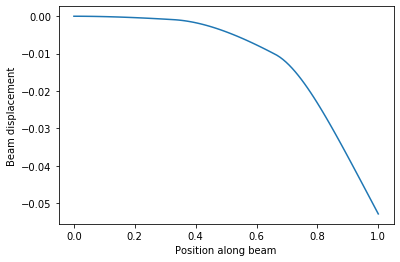

In [3]:
logStiffness = [8.0, 5.0, 2.0]
load = [-0.01]
displ = beam.Evaluate([load, logStiffness])[0]

plt.plot(nodeLocs,displ)
plt.xlabel('Position along beam')
plt.ylabel('Beam displacement')
plt.show()

## Set up the model for PCE construction
To evaluate the Euler-Bernoulli beam model above, two inputs were to the `Evaluate` function.   MUQ's PCE factory, however, only functions with models that have a single input.  The distribution of each component of the model input must also match a standard polynomial family according to the Askey scheme [[Xiu and Karniadakis, 2002]](https://epubs.siam.org/doi/abs/10.1137/S1064827501387826).   For continuous random variables, the Askey scheme is

| Distribution    | Polynomial Family   | Support            |
| ----------------| ------------------- | ------------------ |
| Standard Normal | Probabilist Hermite | $(-\infty,\infty)$ |
| Uniform         | Legendre            | $[-1,1]$           |
| Gamma           | Laguerre            | $[0,\infty)$       |
| Beta            | Jacobi              | $[0,1]$            |

To handle more general Gaussian and uniform distributions, we need to scale the these "normalized" distribution into the inputs of the Euler-Bernoulli beam model.  This can be accomplished with a combination of MUQ's `AffineOperator` and `DiagonalOperator` classes.

Let $\theta = [z_1,z_2,z_3,u]$ be a vector "normalized" variables.  We want to set up a series of operations that splits this vector (using the `SplitVector` class) into the Gaussian components $z_1,z_2,z_3$ and the uniform component $u$ before scaling and shifting the components to match the distributions over the beam stiffnesses $m_i$ and load $f$.  For $m_i \sim N(\mu, \sigma^2)$, the transformation 
$$
m_i = \sigma z_i + \mu
$$
is employed.  Similarly, for $f\sim U\left[f_{lb},f_{ub}\right]$, the transformation 
$$
f = \frac{1}{2}\left[(f_{ub}-f_{lb})u + (f_{lb}+f_{ub})\right]
$$
is used.


In [4]:
logStiffMean = [8.0, 8.0, 8.0]
logStiffStd = [1.5, 1.5, 1.5]

fub = -0.0
flb = -0.1
loadMean = [-0.05]
loadScale = [0.05]

stiffTransform = mm.AffineOperator(mm.DiagonalOperator(logStiffStd), logStiffMean)
loadTransform = mm.AffineOperator(mm.DiagonalOperator([0.5*(fub-flb)]), [0.5*(fub+flb)])

To combine the split, shift, scale, and solve operations, we employ an instance of the MUQ `WorkGraph` to connect the operations.

In [5]:
graph = mm.WorkGraph()
graph.AddNode(mm.SplitVector([0,numBlocks],[numBlocks,1],dim), "Normalized Vars")
graph.AddNode(stiffTransform, "LogStiffness")
graph.AddNode(loadTransform, "Load")

graph.AddNode(beam, "Beam")

graph.AddEdge("Normalized Vars",0,"LogStiffness",0)
graph.AddEdge("Normalized Vars",1,"Load",0)
graph.AddEdge("LogStiffness",0,"Beam",1)
graph.AddEdge("Load",0,"Beam",0)

model = graph.CreateModPiece("Beam")

Visualizing the `WorkGraph` is a good way to ensure that the graph was constructed properly.

In [6]:
graph.Visualize('ModelGraph.png')

<img src="ModelGraph.png" width=600px>

## Define the PCE factory
The next step is to create an instance of the `AdaptiveSmolyakPCE` class, which will evaluate the model and construct the PCE.   This class implements the adaptive pseudo-spectral technique described in [Conrad and Marzouk, 2013](https://epubs.siam.org/doi/10.1137/120890715) and requires us to define the polynomial families used in each direction (according to the Askey scheme above) as well as the quadrature rules used in the adaptive algorithm.   The weight used in the quadrature rule should match the distribution of the input.  For example, we employ a Gauss-Hermite quadrature rule in the Gaussian dimensions and a nested Gauss-Patterson rule in the uniform direction.

In [7]:
# Define the Polynomial families for each input dimension
gaussPoly = ma.ProbabilistHermite()
uniformPoly = ma.Legendre()
polys = [gaussPoly]*numBlocks + [uniformPoly]

# Define the 1D quadrature rules used for each input dimension.
# Gauss-Hermite in the Gaussian directions and Gauss Patterson in the uniform direciton.
gaussQuad = ma.GaussQuadrature(gaussPoly)
uniformQuad = ma.GaussPattersonQuadrature()
quads = [gaussQuad]*numBlocks + [uniformQuad]

# Create the Adaptive Smolyak Solver
smolyPCE = ma.AdaptiveSmolyakPCE(model, quads, polys);

## Construct the PCE
The following cell is where the model is actually evaluated and the PCE is constructed.  The multivariate polynomial terms used in the PCE are tracked through a set of multiindices.  Here, using the `multis` variable, we set the initial terms in the expansion to include all of the linear polynomials.   

Internally, the pseudospectral algorithms approximates the $L_2$ error of the polynomial approximation and stops adapting if the error estimate drops below the `ErrorTol` specified in the `options` dictionary below.

In [8]:
# Start with a linear approximation
initialOrder = 1
multis = mu.MultiIndexFactory.CreateTotalOrder(dim,initialOrder)

options = dict()
options['ShouldAdapt']  = 1    # After constructing an initial approximation with the terms in "multis", should we continue to adapt?
options['ErrorTol']     = 1e-4 # Stop when the estimated L2 error is below this value
options['MaximumEvals'] = 2000 # Stop adapting when more than this many model evaluations has occured

pce = smolyPCE.Compute(multis, options);

## Inspect the results

In [9]:
print('Number of Model Evaluations:')
print(smolyPCE.NumEvals())

print('\nEstimated L2 Error:')
print('%0.4e'%smolyPCE.Error())

Number of Model Evaluations:
1337

Estimated L2 Error:
9.0173e-05


### Plot the convergence diagnostics
The `ErrorHistory()`, `EvalHistory()`, and `TimeHistory()` functions of the `AdaptiveSmolyakPCE` allow us to inspect adaptation history of the PCE factory.   These functions returns vectors with one component for each adaptation iteration.

In [10]:
errorHist = smolyPCE.ErrorHistory() # Estimated L2 error
evalHist = smolyPCE.EvalHistory()   # Number of evaluations
timeHist = smolyPCE.TimeHistory()   # Elapsed time

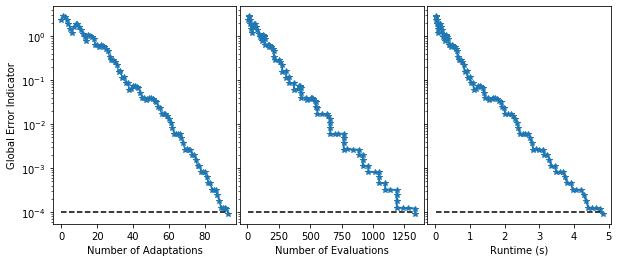

In [11]:
fig, axs = plt.subplots(ncols=3,sharey=True,figsize=(10,4))

axs[0].semilogy(errorHist,'*-')
axs[0].set_ylabel('Global Error Indicator')
axs[0].set_xlabel('Number of Adaptations')
axs[0].semilogy([0, len(errorHist)-1], [options['ErrorTol'],options['ErrorTol']],'--k')

axs[1].semilogy(evalHist, errorHist,'*-',linewidth=2)
axs[1].set_xlabel('Number of Evaluations')
axs[1].semilogy([evalHist[0], evalHist[-1]], [options['ErrorTol'],options['ErrorTol']],'--k')

axs[2].semilogy(timeHist, errorHist,'*-',linewidth=2)
axs[2].semilogy([timeHist[0], timeHist[-1]], [options['ErrorTol'],options['ErrorTol']],'--k')

axs[2].set_xlabel('Runtime (s)')

plt.subplots_adjust(wspace=0.02)
plt.show()

## Predictive Uncertainty
Now that we have a polynomial approximation to the Euler-Bernoulli beam model, we can efficiently look at uncertainty in model predictions of displacement.  

Because we chose polynoimials that are orthogonal with respect to the input measure, moments of the prediction can be computed directly from the coefficients in the polynomial expansion.  This is how MUQ computes the mean and variance in the following cell.   

In [12]:
predMean = pce.Mean()
predVar = pce.Variance()

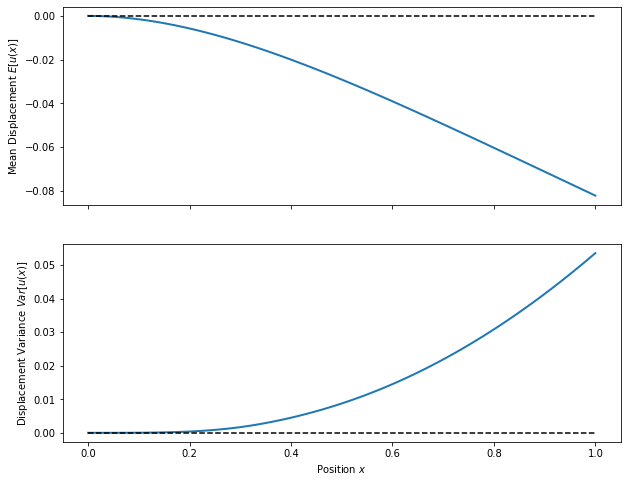

In [13]:
fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(10,8))
axs[0].plot(nodeLocs, predMean,linewidth=2.0)
axs[0].plot([nodeLocs[0], nodeLocs[-1]], [0.0,0.0],'--k')

axs[1].plot(nodeLocs, predVar,linewidth=2.0)
axs[1].plot([nodeLocs[0], nodeLocs[-1]], [0.0,0.0],'--k')

axs[1].set_xlabel('Position $x$')
axs[0].set_ylabel('Mean Displacement $E[u(x)]$')
axs[1].set_ylabel('Displacement Variance ${Var}[u(x)]$')

plt.show()

The entire covariance matrix of the displacements can also be computed efficiently.

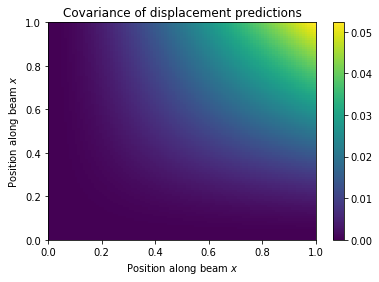

In [14]:
predCov = pce.Covariance()

plt.pcolor(nodeLocs,nodeLocs,predCov)
plt.xlabel('Position along beam $x$')
plt.ylabel('Position along beam $x$')
plt.title('Covariance of displacement predictions')
plt.colorbar()
plt.show()

In addition to analytically available moments, the polynomial approximation of the beam model can also be much faster to evaluate than the original PDE model.   Here, we leverage that fact to estimate quantiles of the predictive distribution with Monte Carlo samples.

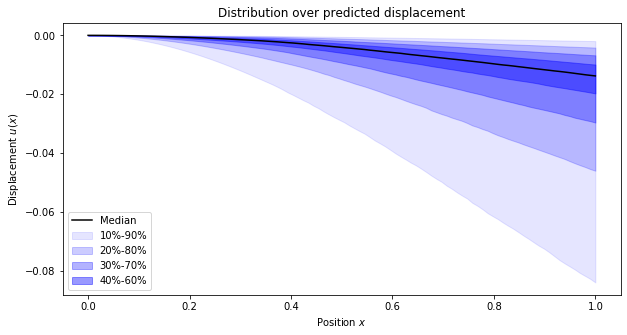

In [15]:
numSamps = 4000
samps = np.hstack([np.random.randn(numSamps,numBlocks), np.random.rand(numSamps,1)])
pred = np.vstack([pce.Evaluate([samps[i,:]])[0] for i in range(numSamps)])

qlevels = [10,20,30,40,60,70,80,90]
qs = [np.percentile(pred,qlevel,axis=0) for qlevel in qlevels]
median = np.percentile(pred,50,axis=0)

plt.figure(figsize=(10,5))
plt.fill_between(nodeLocs, qs[0],qs[-1],color='b',alpha=0.1, label='10%-90%')
plt.fill_between(nodeLocs, qs[1],qs[-2],color='b',alpha=0.2, label='20%-80%')
plt.fill_between(nodeLocs, qs[2],qs[-3],color='b',alpha=0.3, label='30%-70%')
plt.fill_between(nodeLocs, qs[3],qs[-4],color='b',alpha=0.4, label='40%-60%')
plt.plot(nodeLocs,median,'-k',label='Median')
plt.legend()
plt.xlabel('Position $x$')
plt.ylabel('Displacement $u(x)$')
plt.title('Distribution over predicted displacement')
plt.show()

## Sensitivity analysis
Decomposing the prediction variance into partial variances stemming from smaller subsets of the input variables.  The Sobol index for inputs $i_1,\ldots,i_s$ is the ratio of the variance stemming from just inputs $i_1,\ldots,i_s$ to the total variance.  The total sensitivity for a component $j$ is defined similarly, but using partial variances from all terms involving input $j$.   As discussed in Section 5 of 
[[Sudret 2008]](https://www.researchgate.net/profile/Bruno_Sudret/publication/222526449_Global_sensitivity_analysis_using_polynomial_chaos_expansion/links/5a1c302faca272df0811882c/Global-sensitivity-analysis-using-polynomial-chaos-expansion.pdf) it is possible to compute these indices directly from the coefficients of a polynomial chaos expansion.

In the cell below, we compute the Sobol indices (also known as main effects) for each input component and all displacements.

In [16]:
mainEffects = pce.MainSensitivity()
totalSens = pce.TotalSensitivity()

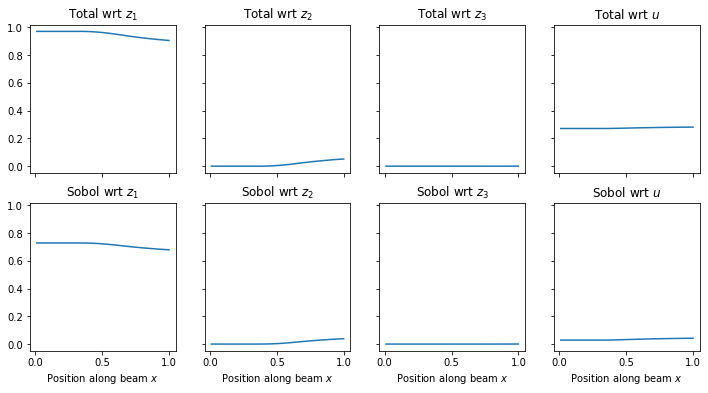

In [17]:
fig,axs = plt.subplots(nrows=2,ncols=4,figsize=(12,6),sharex=True,sharey=True)
varNames = ['$z_1$', '$z_2$', '$z_3$', '$u$']
for i in range(4):
    axs[0,i].plot(nodeLocs, totalSens[:,i])
    axs[0,i].set_title('Total wrt ' + varNames[i])


for i in range(4):
    axs[1,i].plot(nodeLocs, mainEffects[:,i])
    axs[1,i].set_title('Sobol wrt ' + varNames[i])
    axs[1,i].set_xlabel('Position along beam $x$')
plt.show()